In [3]:
# COMP 551, Fall 2024, McGill University
# Assignment 3
# Rob Li, Ian McFarland, Finnley Howald
# 18 November 2024

In [15]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

In [2]:
##### Task 1: Acquire the data

In [3]:
# pip install medmnist

In [16]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from medmnist import OrganAMNIST

import matplotlib.pyplot as plt
import time

In [17]:
### 1.1. Loading the dataset
raw_dataset = OrganAMNIST(split="train", download=True)

Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz


In [18]:
### 1.2. Checking dataset structure
print("Dataset Structure:")
print(f"Type: {type(raw_dataset)}")
print(f"Length: {len(raw_dataset)}")
print(f"Sample structure: {raw_dataset[0]}")

Dataset Structure:
Type: <class 'medmnist.dataset.OrganAMNIST'>
Length: 34561
Sample structure: (<PIL.Image.Image image mode=L size=28x28 at 0x252F528CC40>, array([6]))


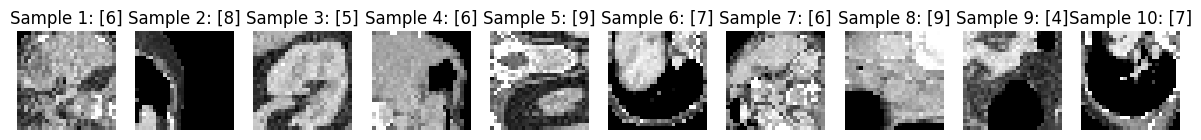

In [19]:
def show_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 7))
    for i in range(num_samples):
        image, label = dataset[i]  # Unpack the data (image and label)
        axes[i].imshow(image, cmap="gray")  # Display the image
        axes[i].set_title(f"Sample {i+1}: {label}")  # Display the label
        axes[i].axis("off")  # Hide axis for better view
    plt.show()

# Show 5 samples from the training dataset
show_samples(raw_dataset)

In [21]:
def mean_var_calc(tr="train"):
  transform = transforms.Compose([transforms.ToTensor()])
  data = OrganAMNIST(split=tr, download=True, transform=transform)
  loader = DataLoader(data, batch_size=1000, shuffle=False) # We could not pass the already loaded dataloader as transform will be different
  sum = 0.0
  squared_sum = 0.0
  N = 0
  for data, _ in loader: # Accumulative sum and std throughout data
    sum += data.sum(dim=[0, 2, 3])
    squared_sum += (data ** 2).sum(dim=[0, 2, 3])
    N += data.numel()
  mean = sum / N
  std = torch.sqrt((squared_sum / N) - (mean ** 2))
  return mean.item(), std.item()

In [22]:
train_mean, train_std = mean_var_calc()
test_mean, test_std = mean_var_calc("test")

Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz


In [23]:
print(train_mean, train_std)
print(test_mean, test_std)

0.4680282771587372 0.297420859336853
0.46014639735221863 0.2833701968193054


In [24]:
### 1.3. Loading the dataset as a flattened and normalized vector
transform_28 = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

transform_128 = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=test_mean, std=test_std),
    transforms.Resize(128),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 128x128 image to 16384
])



# Load dataset with transformations applied
train_dataset = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_28)
test_dataset = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_28)

train_unnormalized_dataset = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_unnormalized)
test_unnormalized_dataset = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_unnormalized)

train_dataset_128 = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_128)
test_dataset_128 = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_128)

# Create a DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_unnormalized_loader = DataLoader(train_unnormalized_dataset, batch_size=batch_size, shuffle=True)
test_unnormalized_loader = DataLoader(test_unnormalized_dataset, batch_size=batch_size, shuffle=True)

train_loader_128 = DataLoader(train_dataset_128, batch_size=batch_size, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=batch_size, shuffle=True)

# Check a batch to ensure transformations are applied correctly
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")  # Expected shape: [batch_size, 784]
print(f"Batch of labels shape: {labels.shape}")

Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Batch of images shape: torch.Size([64, 784])
Batch of labels shape: torch.Size([64, 1])


In [25]:
X_train, Y_train, X_train_unnormalized, Y_train_unnormalized, X_train_128, Y_train_128 = [], [], [], [], [], []
X_test, Y_test, X_test_unnormalized, Y_test_unnormalized, X_test_128, Y_test_128 = [], [], [], [], [], []
for images, labels in train_loader:
  X_train.append(images.numpy())
  Y_train.append(labels.numpy())
for images, labels in test_loader:
  X_test.append(images.numpy())
  Y_test.append(labels.numpy())

for images, labels in train_unnormalized_loader:
  X_train_unnormalized.append(images.numpy())
  Y_train_unnormalized.append(labels.numpy())
for images, labels in test_unnormalized_loader:
  X_test_unnormalized.append(images.numpy())
  Y_test_unnormalized.append(labels.numpy())

for images, labels in train_loader_128:
  X_train_128.append(images.numpy())
  Y_train_128.append(labels.numpy())

for images, labels in test_loader_128:
  X_test_128.append(images.numpy())
  Y_test_128.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0).squeeze()

X_train_unnormalized = np.concatenate(X_train_unnormalized, axis=0)
Y_train_unnormalized = np.concatenate(Y_train_unnormalized, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test_unnormalized = np.concatenate(X_test_unnormalized, axis=0)
Y_test_unnormalized = np.concatenate(Y_test_unnormalized, axis=0).squeeze()

X_train_128 = np.concatenate(X_train_128, axis=0)
Y_train_128 = np.concatenate(Y_train_128, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test_128 = np.concatenate(X_test_128, axis=0)
Y_test_128 = np.concatenate(Y_test_128, axis=0).squeeze()


def one_hot_encode(y, num_classes=11):
  one_hot = np.zeros((y.size, num_classes))
  one_hot[np.arange(y.size), y] = 1
  return one_hot

Y_train_encoded = one_hot_encode(Y_train)
Y_test_encoded = one_hot_encode(Y_test)

Y_train_unnormalized_encoded = one_hot_encode(Y_train_unnormalized)
Y_test_unnormalized_encoded = one_hot_encode(Y_test_unnormalized)

Y_train_128_encoded = one_hot_encode(Y_train_128)
Y_test_128_encoded = one_hot_encode(Y_test_128)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_train_encoded shape: {Y_train_encoded.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Y_test_encoded shape: {Y_test_encoded.shape}")

print(f"X_train_unnormalized shape: {X_train_unnormalized.shape}")
print(f"Y_train_unnormalized shape: {Y_train_unnormalized.shape}")
print(f"Y_train_unnormalized_encoded shape: {Y_train_unnormalized_encoded.shape}")
print(f"X_test_unnormalized shape: {X_test_unnormalized.shape}")
print(f"Y_test_unnormalized shape: {Y_test_unnormalized.shape}")
print(f"Y_test_unnormalized_encoded shape: {Y_test_unnormalized_encoded.shape}")

print(f"X_train_128 shape: {X_train_128.shape}")
print(f"Y_train_128 shape: {Y_train_128.shape}")
print(f"Y_train_128_encoded shape: {Y_train_128_encoded.shape}")
print(f"X_test_128 shape: {X_test_128.shape}")
print(f"Y_test_128 shape: {Y_test_128.shape}")
print(f"Y_test_128_encoded shape: {Y_test_128_encoded.shape}")

# Y encoded is for training purposes in the fit function
# Use Y raw for accuracy evalation and testing as the model's final prediction is just the class number

X_train shape: (34561, 784)
Y_train shape: (34561,)
Y_train_encoded shape: (34561, 11)
X_test shape: (17778, 784)
Y_test shape: (17778,)
Y_test_encoded shape: (17778, 11)
X_train_unnormalized shape: (34561, 784)
Y_train_unnormalized shape: (34561,)
Y_train_unnormalized_encoded shape: (34561, 11)
X_test_unnormalized shape: (17778, 784)
Y_test_unnormalized shape: (17778,)
Y_test_unnormalized_encoded shape: (17778, 11)
X_train_128 shape: (34561, 16384)
Y_train_128 shape: (34561,)
Y_train_128_encoded shape: (34561, 11)
X_test_128 shape: (17778, 16384)
Y_test_128 shape: (17778,)
Y_test_128_encoded shape: (17778, 11)


In [26]:
# Activation function library
def softmax(z):
  exps = np.exp(z)
  return exps / np.sum(exps, axis=1, keepdims=True)

class ActivationFunction:
    def function(self, x):
        raise NotImplementedError("Function method not implemented.")

    def derivative(self, x):
        raise NotImplementedError("Derivative method not implemented.")

class ReLU(ActivationFunction):
    def function(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x > 0, 1, 0)
    
class LeakyReLU(ActivationFunction):
    def function(self, x):
        return np.where(x > 0, x, x * 0.01)
    def derivative(self, x):
        return np.where(x > 0, 1, 0.01)

class Sigmoid(ActivationFunction):
    def function(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        sig = self.function(x)
        return sig * (1 - sig)

class Tanh(ActivationFunction):
    def function(self, x):
        return np.tanh(x)

    def derivative(self, x):
        return 1 - np.tanh(x) ** 2
    
logistic = lambda z: 1./ (1 + np.exp(-z))


In [27]:
##### Task 2: Implement a Multilayer Perceptron
class MultilayerPerceptron:

  def __init__(self, activation_function = ReLU, hidden_layers = 2, hidden_layer_widths = [64,64], input_width = 784, output_width = 11, regularization = None, regularization_lambda = 0.01, print_loss = False, normalized = True, big_images = False):
    if (len(hidden_layer_widths) != hidden_layers):
      raise ValueError("Number of hidden layers does not match the size of layer_widths in MultilayerPerceptron initalization")
    
    self.activation_function = activation_function
    self.regularization = regularization
    self.regularization_lambda = regularization_lambda
    self.print_loss = print_loss
    layer_sizes = [input_width] + hidden_layer_widths + [output_width]
    self.weights = []
    self.biases = []
    self.epoch_losses = []
    self.losses = []
    self.train_accuracies = []
    self.test_accuracies = []
    self.hidden_layers = hidden_layers
    self.normalized = normalized
    self.big_images = big_images
    self.training_time = 0
    self.input_width = input_width

    for i in range (len(layer_sizes) - 1):
      weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
      self.weights.append(weight_matrix)
      bias_vector = np.zeros((1, layer_sizes[i + 1]))
      self.biases.append(bias_vector)

  def calculate_loss(self, Y, Y_hat):
    # Cross-entropy loss
    data_loss = -np.mean(np.sum(Y * np.log(Y_hat + 1e-8), axis=1))
    regularization_loss = 0

    if self.regularization == "L2":
        for weight in self.weights:
            regularization_loss += 0.5 * self.regularization_lambda * np.sum(weight * weight)
    elif self.regularization == "L1":
        for weight in self.weights:
            regularization_loss += self.regularization_lambda * np.sum(np.abs(weight))

    # Total loss
    total_loss = data_loss + regularization_loss
    return total_loss
  
  def evaluate_acc(self, y, y_hat):
    if len(y) != len(y_hat):
      raise ValueError("Size mismatch: y and y_hat must have the same length in evaluate_acc.")
    # Calculate the mean of correct predictions
    accuracy = np.mean(y == y_hat)
    return accuracy * 100
  
  def plot_loss(self):
      epochs = range(1, len(self.losses) + 1)
      plt.figure(figsize=(10, 6))
      plt.plot(epochs, self.losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss (Cross-Entropy in %)')
      plt.title('Loss vs Epoch')
      plt.legend()
      plt.grid(True)
      plt.show()

  def plot_accuracy(self):
    epochs = range(1, len(self.train_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
    plt.plot(epochs, self.test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Test Accuracy vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

  def print(self):
    if self.regularization:
        regularization_str = f"{self.regularization} regularization and lambda = {self.regularization_lambda}"
    else:
        regularization_str = "no regularization"

    if self.normalized:
        normalization_str = "with normalized data"
    else:
        normalization_str = "with unnormalized data"

    if self.big_images:
        image_str = "and 128x128 images"
    else:
        image_str = ""

    print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, {regularization_str} {normalization_str} {image_str}')
    self.plot_loss()
    self.plot_accuracy()
    print(f"Training time: {self.training_time:.4f} seconds")

  def fit(self, X, Y, learning_rate = 0.01, epochs = 1e4, batch_size = 32):
    training_time = 0
    start_time = time.time()

    N, D = X.shape

    for epoch in range(epochs):
      self.epoch_losses = []

      # Batch splitting
      indicies = np.arange(N)
      np.random.shuffle(indicies)
      X = X[indicies]
      Y = Y[indicies]

      for index in range(0, N, batch_size):
        X_batch = X[index:index+batch_size]
        Y_batch = Y[index:index+batch_size]

        # Activations
        activations = [X_batch]
        Z_values = []

        # Forward Pass
        for j in range(len(self.weights)):
          Z = np.dot(activations[-1], self.weights[j]) + self.biases[j]
          Z_values.append(Z)

          if j < len(self.weights) - 1: # Hidden Layers 
            A = self.activation_function.function(self, Z)
            
          else: # Output Layer
            A = softmax(Z)

          activations.append(A)

        # Loss Calculation
        loss = self.calculate_loss(activations[-1], Y_batch)
        self.epoch_losses.append(loss)

        # Backward Pass
        dLdAj = activations[-1] - Y_batch  # For Loss partial with softmax simplified under cross-entropy (yhat - y)

        if len(self.weights) == 1: 
          for j in reversed(range(len(self.weights))):
            dLdZj = dLdAj
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj
           
            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj
        
        else: 
          for j in reversed(range(1, len(self.weights))):
            dLdZj = dLdAj
            
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj

            if self.regularization == "L2":
              dLdWj += self.regularization_lambda * self.weights[j]
            elif self.regularization == "L1":
              dLdWj += self.regularization_lambda * np.sign(self.weights[j])
            
            if j > 0:
              dLdAj = np.dot(dLdZj, self.weights[j].T) * self.activation_function.derivative(self, Z_values[j-1]) # Partial of Loss w/resp to activation at j Aj

            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj

      training_time += time.time() - start_time

      self.losses.append(np.mean(self.epoch_losses))

      if self.input_width == 784:
        train_predictions = self.predict(X_train)
        train_accuracy = self.evaluate_acc(Y_train, train_predictions)
        self.train_accuracies.append(train_accuracy)

        # Calculate and store testing accuracy
        test_predictions = self.predict(X_test)
        test_accuracy = self.evaluate_acc(Y_test, test_predictions)
        self.test_accuracies.append(test_accuracy)
      
      elif self.input_width == 16384:
        train_predictions = self.predict(X_train_128)
        train_accuracy = self.evaluate_acc(Y_train_128, train_predictions)
        self.train_accuracies.append(train_accuracy)

        # Calculate and store testing accuracy
        test_predictions = self.predict(X_test_128)
        test_accuracy = self.evaluate_acc(Y_test_128, test_predictions)
        self.test_accuracies.append(test_accuracy)

        # Restart the timer
      start_time = time.time()


    self.training_time = training_time

    return self

  def predict(self, X):
    A = X

    for j in range(len(self.weights)):
      Z = np.dot(A, self.weights[j]) + self.biases[j]

      if j < len(self.weights) - 1:
        A = self.activation_function.function(self, Z)

      else:
        A = softmax(Z)

    return np.argmax(A, axis=1)


In [28]:
def evaluate_acc(y, y_hat):
  if len(y) != len(y_hat):
    raise ValueError("Size mismatch: y and y_hat must have the same length in evaluate_acc.")
  # Calculate the mean of correct predictions
  accuracy = np.mean(y == y_hat)
  return accuracy * 100

Model: 0 hidden layers, ReLU activation function, no regularization with normalized data 


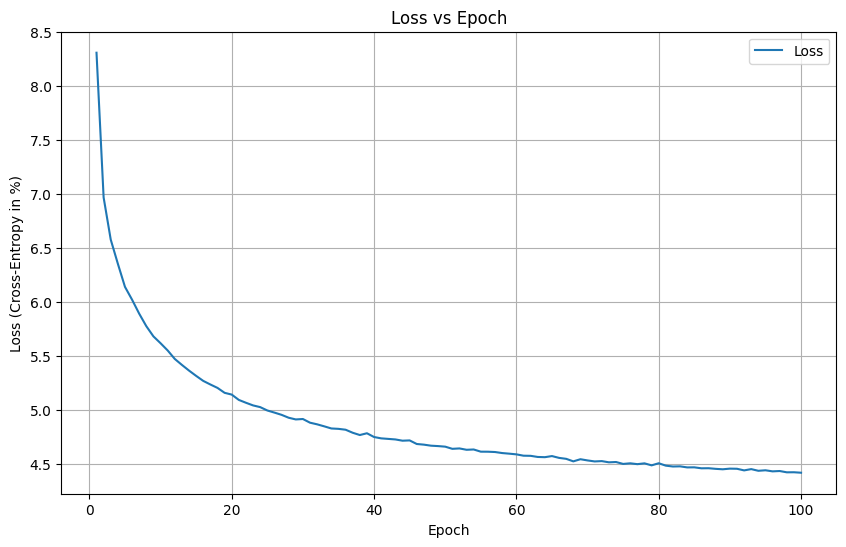

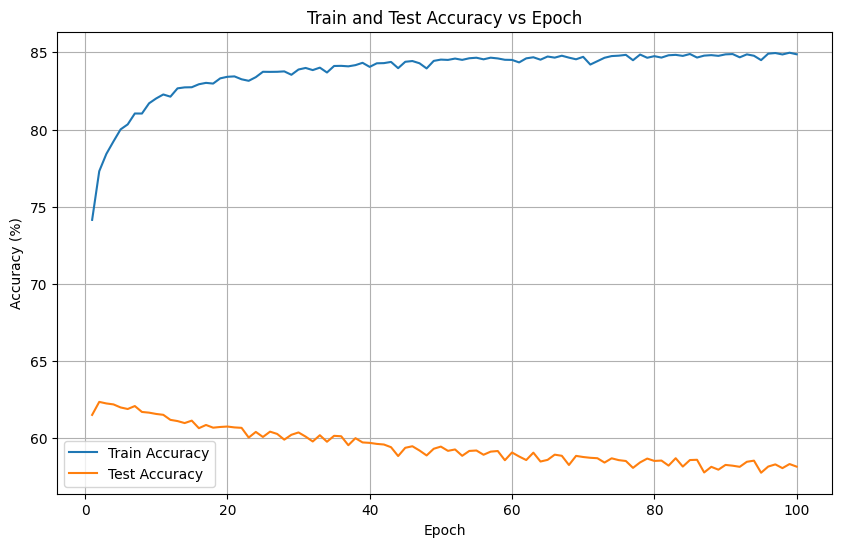

Training time: 9.8615 seconds
Accuracy of model 1: 58.156%
-------------------------------
 
Model: 1 hidden layers, ReLU activation function, no regularization with normalized data 


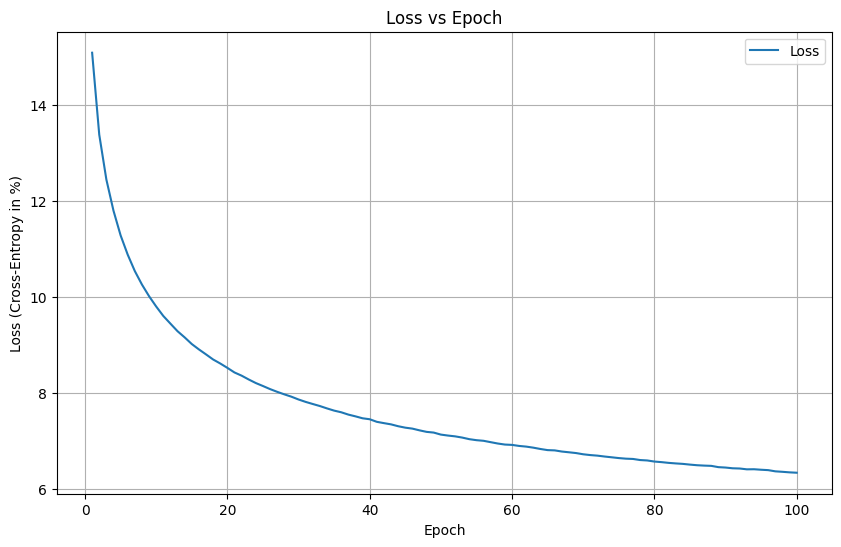

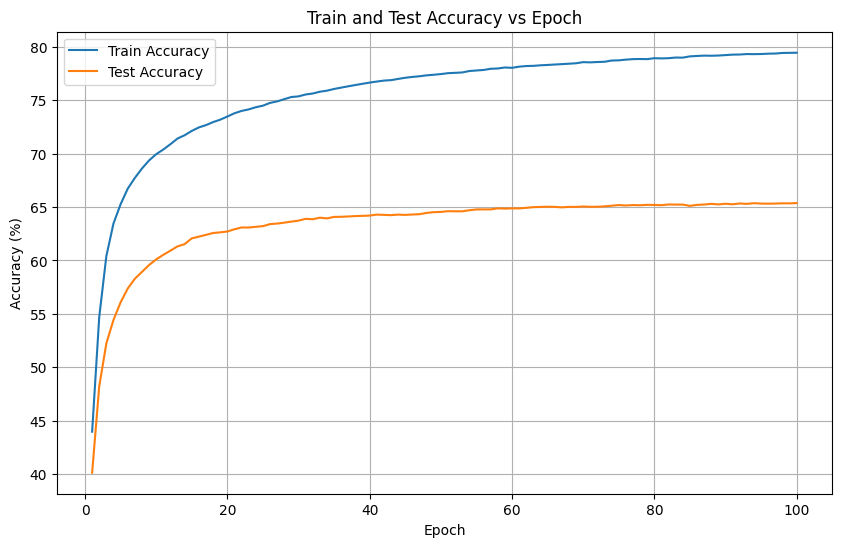

Training time: 27.2652 seconds
Accuracy of model 2: 65.373%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, no regularization with normalized data 


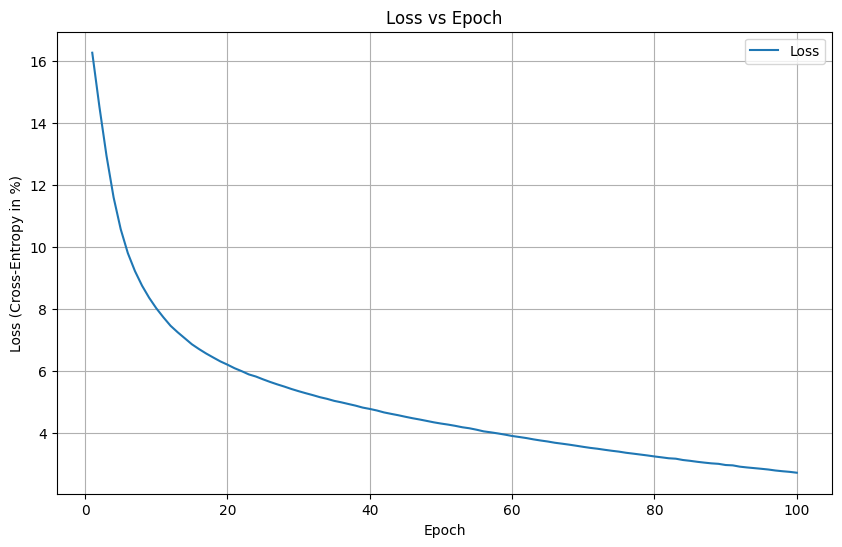

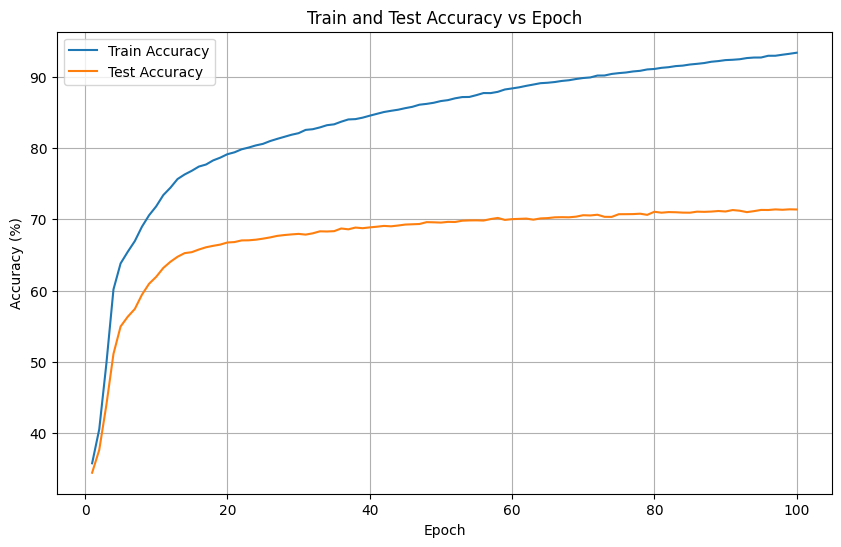

Training time: 58.9075 seconds
Accuracy of model 3: 71.375%


In [20]:
# 3.1 

# MLP no hidden layers
mlp = MultilayerPerceptron(hidden_layers=0, hidden_layer_widths=[], print_loss=False)
mlp.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat = mlp.predict(X_test)
accuracy = evaluate_acc(Y_test, Y_hat)
mlp.print()
print(f"Accuracy of model 1: {accuracy:.3f}%")

print("-------------------------------")
print(" ")

# MLP 1 hidden layer, 256 and ReLU
mlp2 = MultilayerPerceptron(hidden_layers=1, hidden_layer_widths=[256])
mlp2.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat2 = mlp2.predict(X_test)
accuracy2 = evaluate_acc(Y_test, Y_hat2)
mlp2.print()
print(f"Accuracy of model 2: {accuracy2:.3f}%")

print("-------------------------------")
print(" ")

# MLP 2 hidden layers, 256 and ReLU
mlp3 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256])
mlp3.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat3 = mlp3.predict(X_test)
accuracy3 = evaluate_acc(Y_test, Y_hat3)
mlp3.print()
print(f"Accuracy of model 3: {accuracy3:.3f}%")

Testing learning rate: 0.001
Finished training for learning rate 0.001
-------------------------------
Testing learning rate: 0.01
Finished training for learning rate 0.01
-------------------------------
Testing learning rate: 0.1
Finished training for learning rate 0.1
-------------------------------


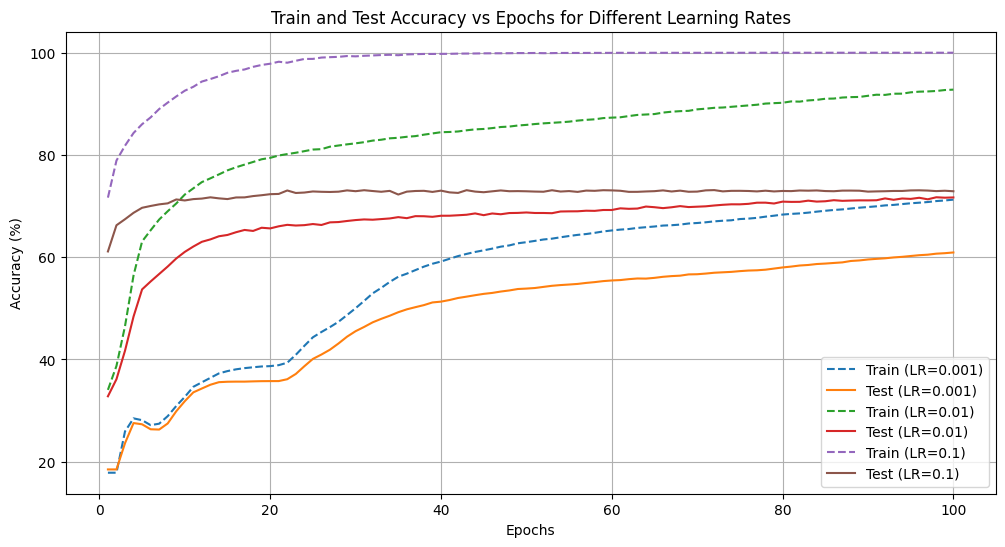

In [ ]:
# Testing learning rates 

learning_rates = [0.001, 0.01, 0.1]
train_accuracies_by_lr = []
test_accuracies_by_lr = []

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    
    mlp3 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256])
    mlp3.fit(X_train, Y_train_encoded, learning_rate=lr, epochs=100, batch_size=32)
    
    train_accuracies_by_lr.append(mlp3.train_accuracies)
    test_accuracies_by_lr.append(mlp3.test_accuracies)
    
    print(f"Finished training for learning rate {lr}")
    print("-------------------------------")

# Plot train and test accuracies for each learning rate
epochs = range(1, 101)

plt.figure(figsize=(12, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(epochs, train_accuracies_by_lr[i], label=f"Train (LR={lr})", linestyle='--')
    plt.plot(epochs, test_accuracies_by_lr[i], label=f"Test (LR={lr})")
    
plt.title("Train and Test Accuracy vs Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


Model: 2 hidden layers, Tanh activation function, no regularization with normalized data 


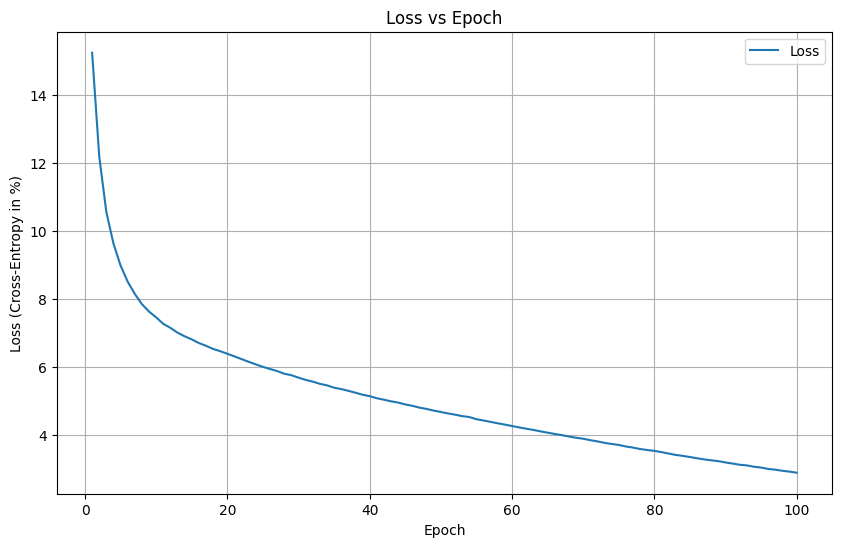

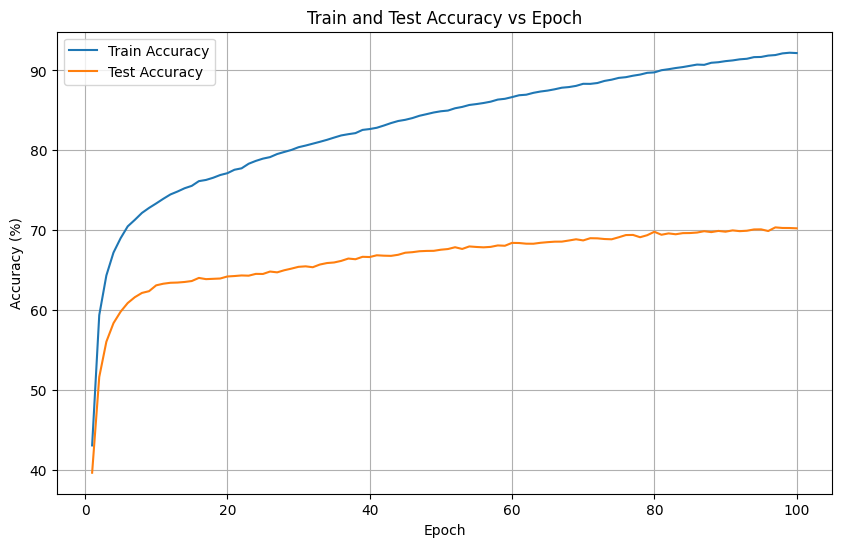

Training time: 85.1576 seconds
Accuracy of model 4: 70.227%
-------------------------------
 
Model: 2 hidden layers, LeakyReLU activation function, no regularization with normalized data 


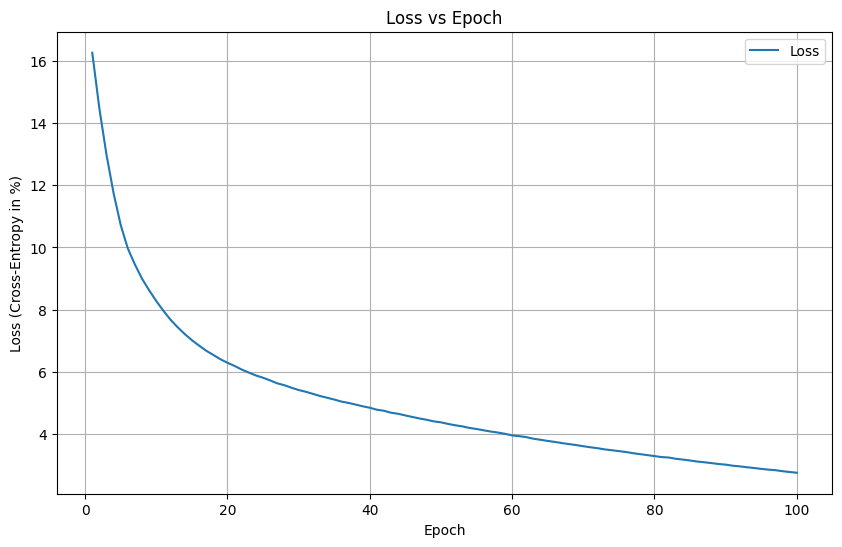

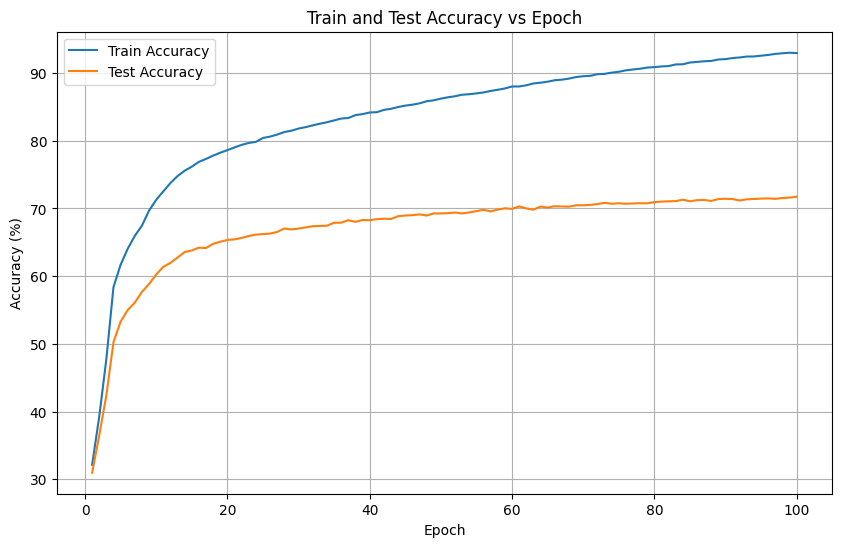

Training time: 62.9936 seconds
Accuracy of model 5: 71.740%


In [21]:
# 3.2: 2 Layer MLPs, now using TanH and Leaky ReLU
mlp4 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=Tanh)
mlp4.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat4 = mlp4.predict(X_test)
accuracy4 = evaluate_acc(Y_test, Y_hat4)
mlp4.print()
print(f"Accuracy of model 4: {accuracy4:.3f}%")

print("-------------------------------")
print(" ")

mlp5 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=LeakyReLU)
mlp5.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat5 = mlp5.predict(X_test)
accuracy5 = evaluate_acc(Y_test, Y_hat5)
mlp5.print()
print(f"Accuracy of model 5: {accuracy5:.3f}%")


Model: 2 hidden layers, ReLU activation function, L1 regularization and lambda = 0.001 with normalized data 


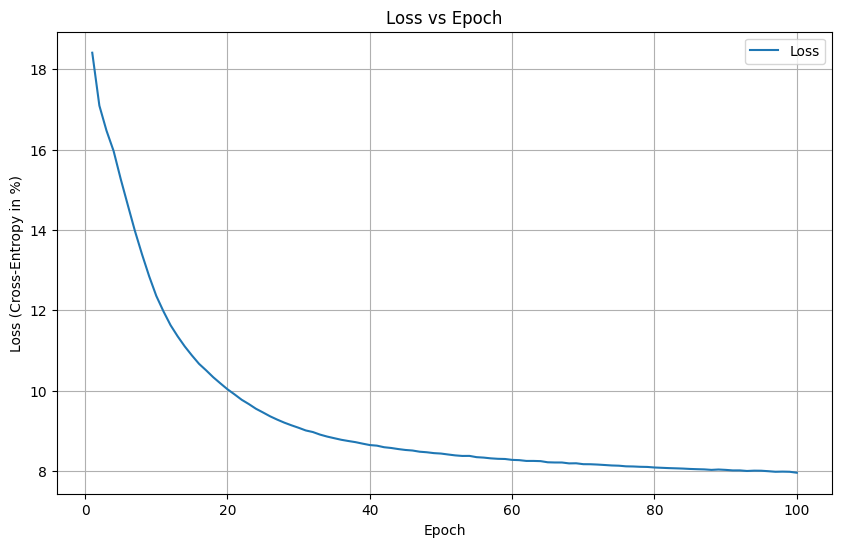

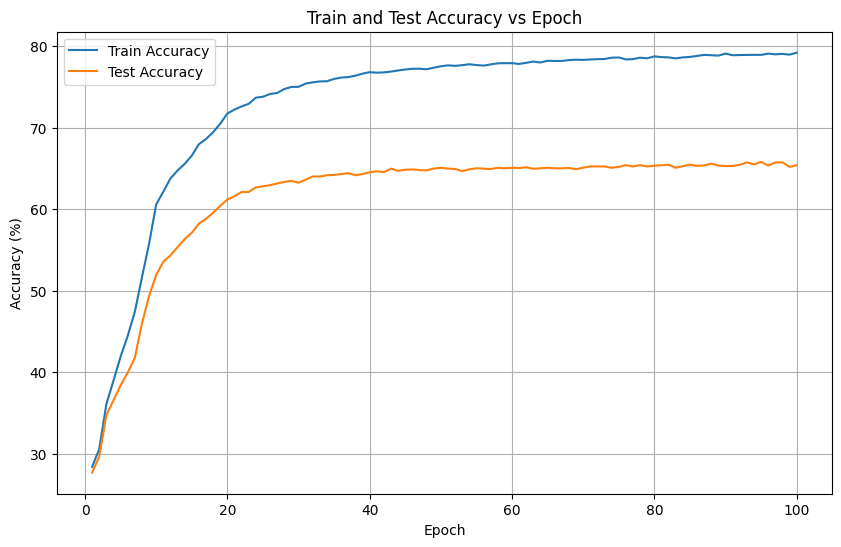

Training time: 130.7912 seconds
Accuracy of model 6: 65.407%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, L2 regularization and lambda = 0.001 with normalized data 


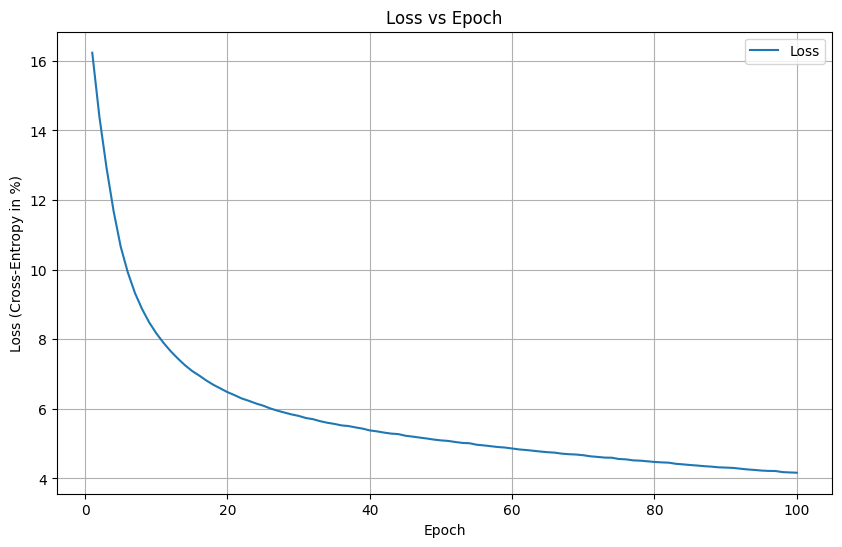

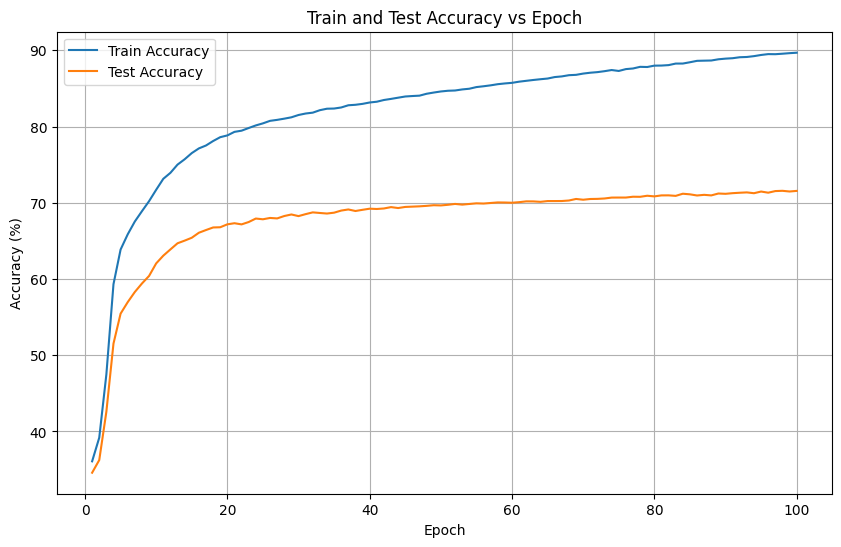

Training time: 98.0036 seconds
Accuracy of model 7: 71.560%


In [22]:
# 3.3 2 Layer MLPs, now using L1 and L2 regularization

mlp6 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L1", regularization_lambda=0.001)
mlp6.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat6 = mlp6.predict(X_test)
accuracy6 = evaluate_acc(Y_test, Y_hat6)
mlp6.print()
print(f"Accuracy of model 6: {accuracy6:.3f}%")

print("-------------------------------")
print(" ")

mlp7 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L2", regularization_lambda=0.001)
mlp7.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat7 = mlp7.predict(X_test)
accuracy7 = evaluate_acc(Y_test, Y_hat7)
mlp7.print()
print(f"Accuracy of model 7: {accuracy7:.3f}%")

Model: 2 hidden layers, ReLU activation function, L1 regularization and lambda = 0.001 with normalized data 


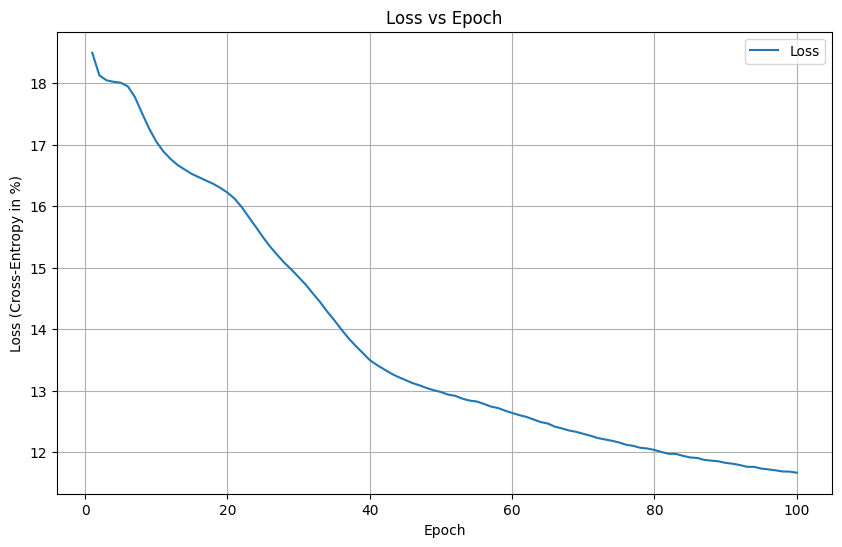

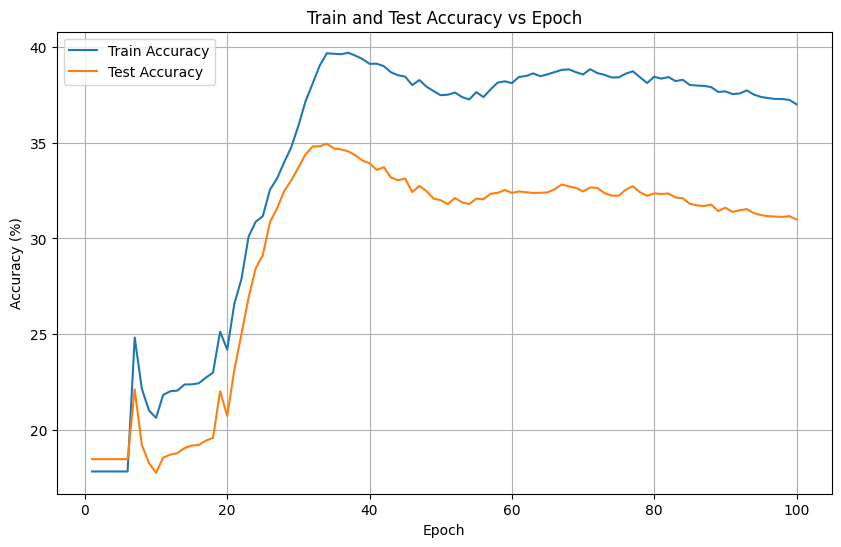

Training time: 136.1943 seconds
Accuracy of model 9: 50.084%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, L2 regularization and lambda = 0.001 with normalized data 


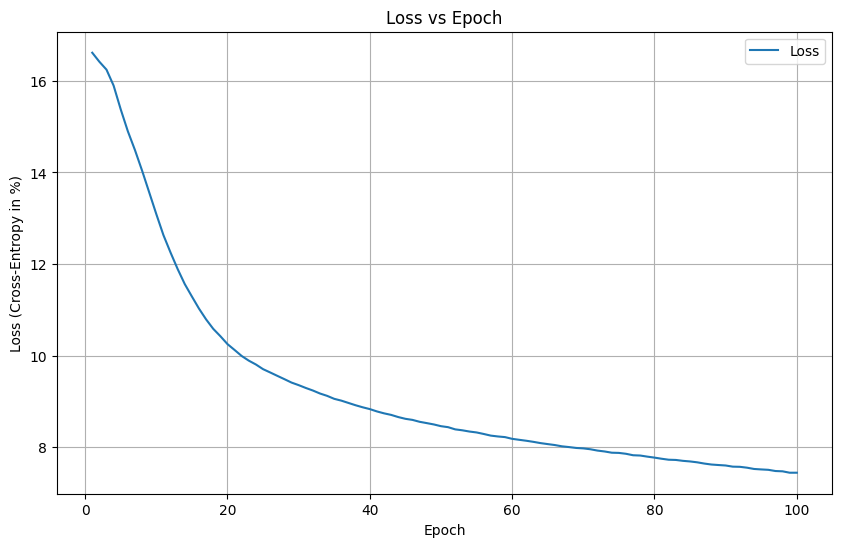

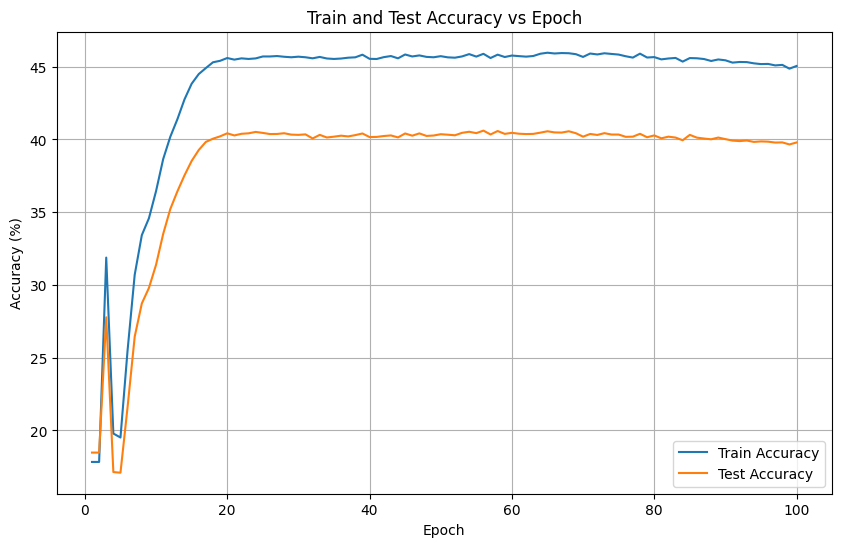

Training time: 103.7076 seconds
Accuracy of model 8: 64.872%


In [23]:
# 3.4 Unnormalized data
mlp9 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L1", regularization_lambda=0.001)
mlp9.fit(X_train_unnormalized, Y_train_unnormalized_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat9 = mlp9.predict(X_test_unnormalized)
accuracy9 = evaluate_acc(Y_test_unnormalized, Y_hat9)
mlp9.print()
print(f"Accuracy of model 9: {accuracy9:.3f}%")

print("-------------------------------")
print(" ")

mlp8 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L2", regularization_lambda=0.001)
mlp8.fit(X_train_unnormalized, Y_train_unnormalized_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat8 = mlp8.predict(X_test_unnormalized)
accuracy8 = evaluate_acc(Y_test_unnormalized, Y_hat8)
mlp8.print()
print(f"Accuracy of model 8: {accuracy8:.3f}%")


Model: 2 hidden layers, ReLU activation function, no regularization with normalized data 


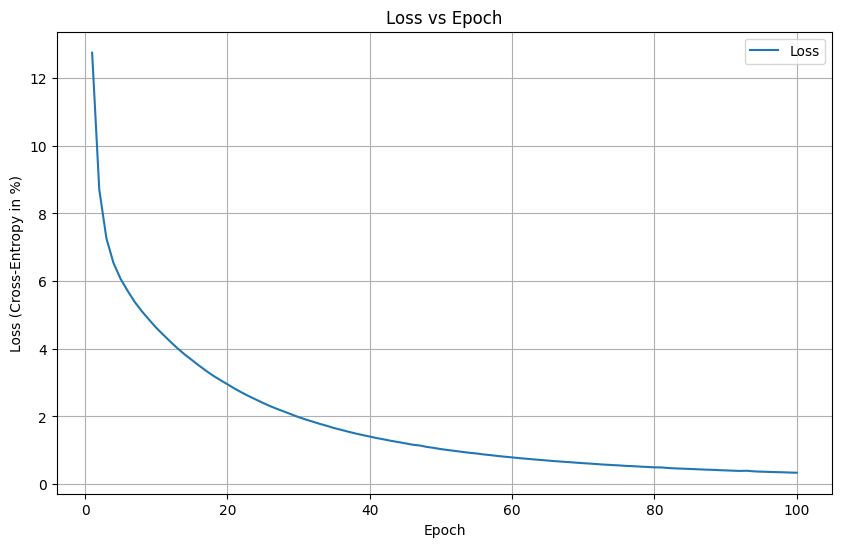

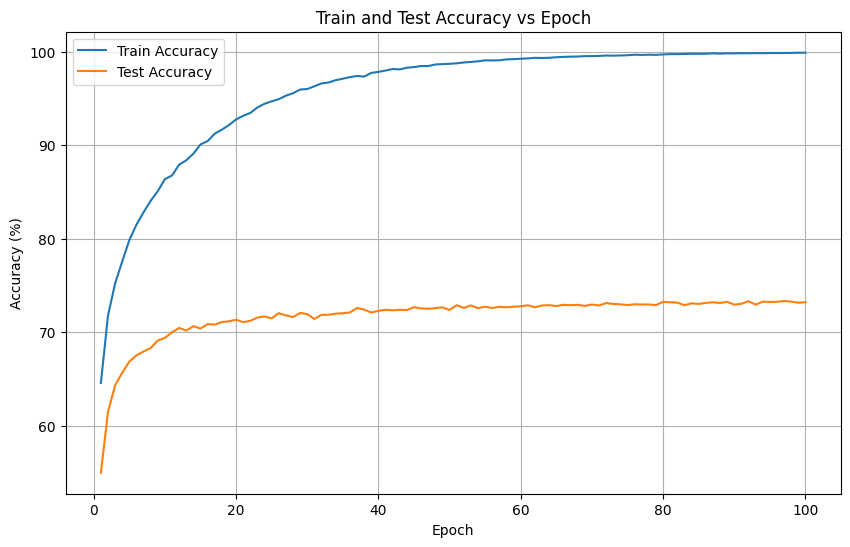

Training time: 408.8371 seconds
Accuracy of model 10: 73.220%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, L1 regularization and lambda = 0.001 with normalized data 


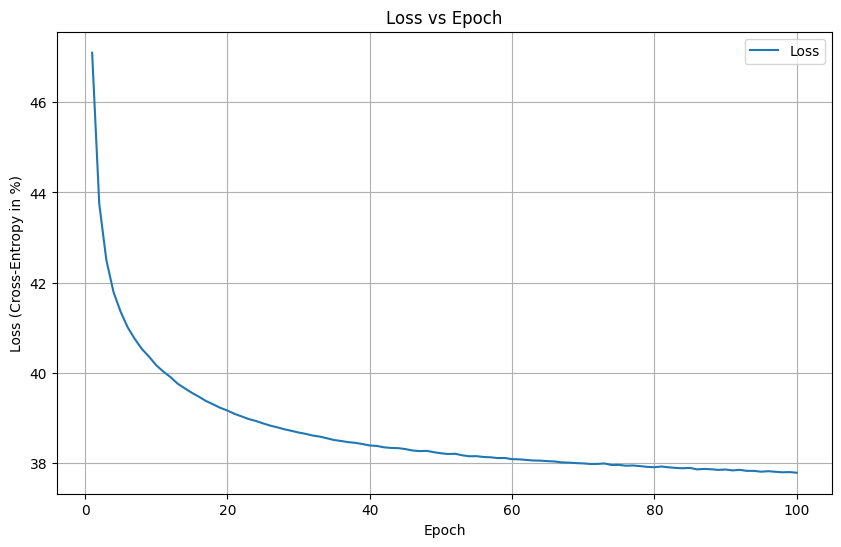

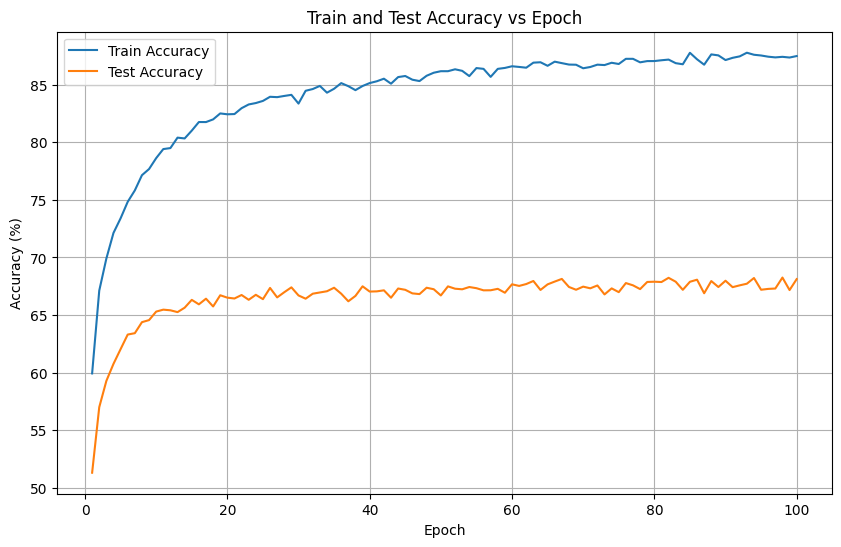

Training time: 1470.3378 seconds
Accuracy of model 11: 68.118%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, L2 regularization and lambda = 0.001 with normalized data 


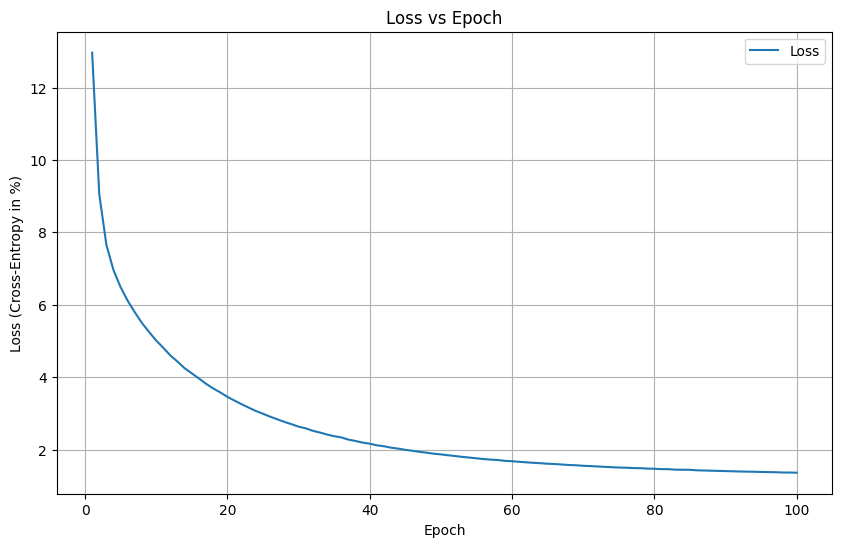

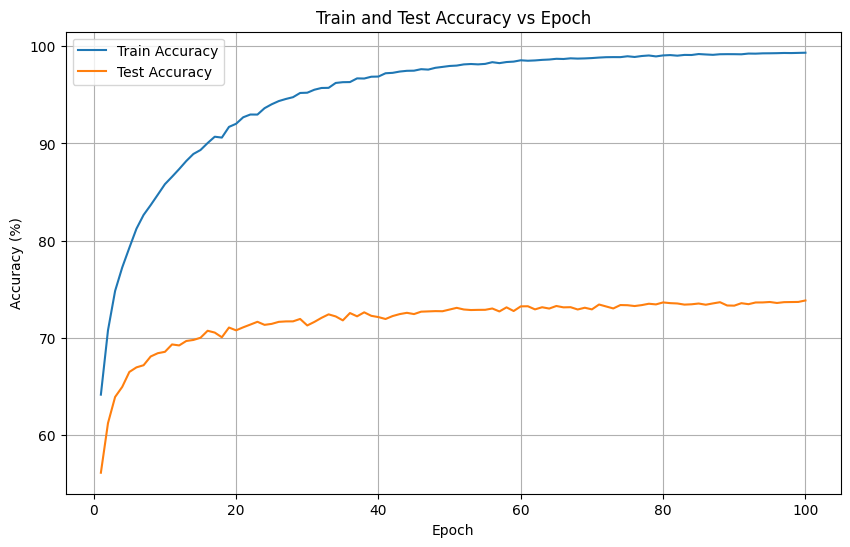

Training time: 1414.0573 seconds
Accuracy of model 12: 73.850%


In [24]:
# 3.5 128x128 images

# No regularization
mlp10 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384)
mlp10.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat10 = mlp10.predict(X_test_128)
accuracy10 = evaluate_acc(Y_test_128, Y_hat10)
mlp10.print()
print(f"Accuracy of model 10: {accuracy10:.3f}%")

print("-------------------------------")
print(" ")

# L1 regularization
mlp11 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384, regularization="L1", regularization_lambda=0.001)
start_time = time.time()
mlp11.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
time_to_train = time.time() - start_time
Y_hat11 = mlp11.predict(X_test_128)
accuracy11 = evaluate_acc(Y_test_128, Y_hat11)
mlp11.print()
print(f"Accuracy of model 11: {accuracy11:.3f}%")

print("-------------------------------")
print(" ")

# L2 regularization
mlp12 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384, regularization="L2", regularization_lambda=0.001)
start_time = time.time()
mlp12.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
time_to_train = time.time() - start_time
Y_hat12 = mlp12.predict(X_test_128)
accuracy12 = evaluate_acc(Y_test_128, Y_hat12)
mlp12.print()
print(f"Accuracy of model 12: {accuracy12:.3f}%")

Testing LR=0.01, Filters=16
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Epoch 1/10, Loss: 0.0070, Train Acc: 84.53%, Val Acc: 93.18%, Time: 9.14s
Epoch 2/10, Loss: 0.0029, Train Acc: 93.88%, Val Acc: 94.61%, Time: 7.67s
Epoch 3/10, Loss: 0.0017, Train Acc: 96.43%, Val Acc: 92.42%, Time: 7.63s
Epoch 4/10, Loss: 0.0018, Train Acc: 96.38%, Val Acc: 94.64%, Time: 8.21s
Epoch 5/10, Loss: 0.0012, Train Acc: 97.54%, Val Acc: 93.54%, Time: 8.06s
Epoch 6/10, Loss: 0.0004, Train Acc: 99.09%, Val Acc: 95.89%, Time: 9.34s
Epoch 7/10, Loss: 0.0003, Train Acc: 99.41%, Val Acc: 95.98%, Time: 8.61s
Epoch 8/10, Loss: 0.0004, Train Acc: 99.22%, Val Acc: 94.22%, Time: 7.89s
Epoch 9/10, Loss: 0.0005, Train Acc: 99.13%, Val Acc: 95.16%, Time: 7.76s
Epoch 10/10, Loss: 0.0004, Train Acc: 99.24%, Val Acc: 95.49%, Time: 7.80s


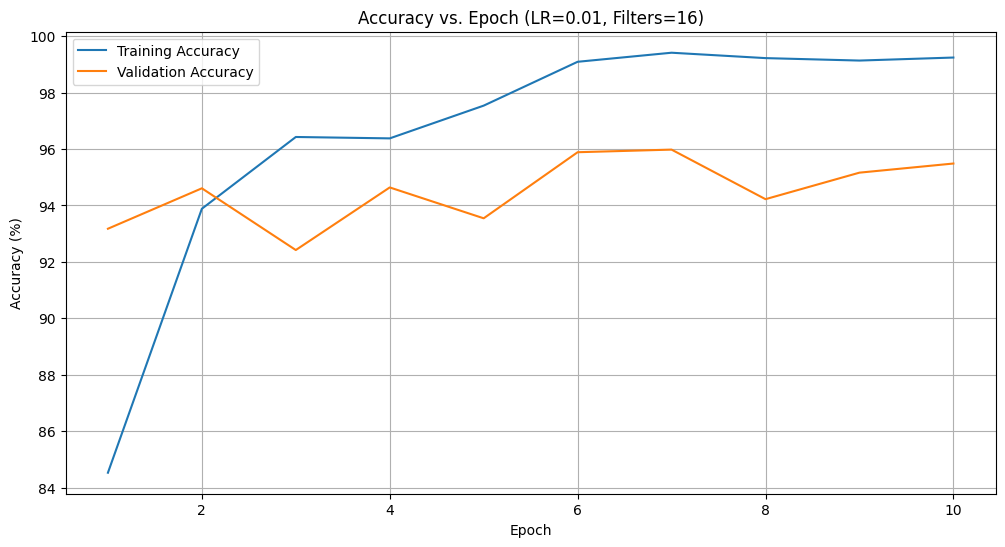

Best Validation Accuracy: 95.98%
Total Training Time: 82.12s
Testing LR=0.01, Filters=32
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Epoch 1/10, Loss: 0.0093, Train Acc: 79.21%, Val Acc: 94.21%, Time: 8.08s
Epoch 2/10, Loss: 0.0038, Train Acc: 91.70%, Val Acc: 93.68%, Time: 8.07s
Epoch 3/10, Loss: 0.0028, Train Acc: 93.76%, Val Acc: 95.29%, Time: 7.75s
Epoch 4/10, Loss: 0.0022, Train Acc: 95.14%, Val Acc: 94.39%, Time: 7.92s
Epoch 5/10, Loss: 0.0019, Train Acc: 95.95%, Val Acc: 93.88%, Time: 8.56s
Epoch 6/10, Loss: 0.0009, Train Acc: 97.98%, Val Acc: 95.27%, Time: 8.16s
Epoch 7/10, Loss: 0.0007, Train Acc: 98.61%, Val Acc: 95.58%, Time: 8.78s
Epoch 8/10, Loss: 0.0006, Train Acc: 98.73%, Val Acc: 94.95%, Time: 9.18s
Epoch 9/10, Loss: 0.0008, Train Acc: 98.22%, Val Acc: 95.49%, Time: 8.74s
Epoch 10/10, Loss: 0.0007, Train Acc: 98.58%, Val Acc: 94.82%, Time: 8.76s


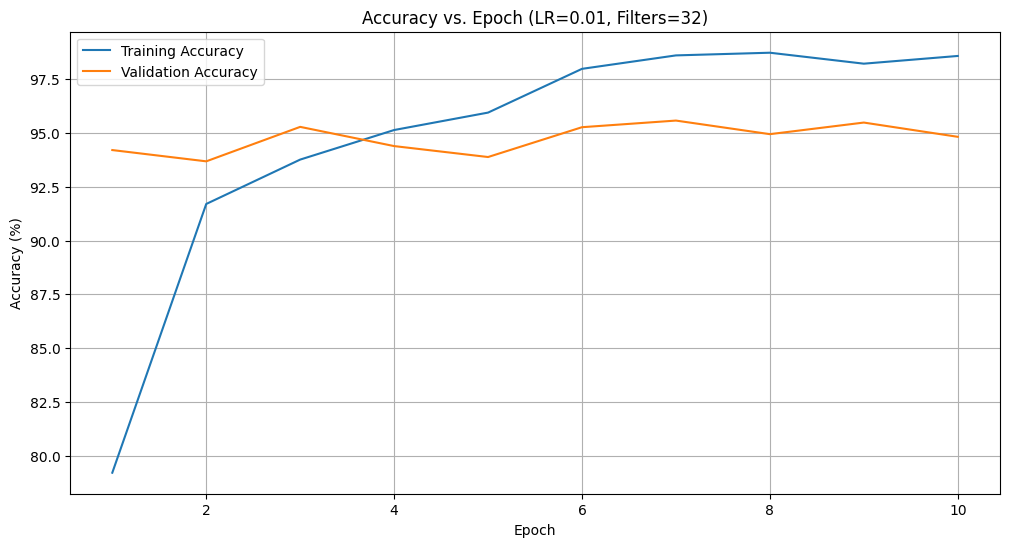

Best Validation Accuracy: 95.58%
Total Training Time: 83.99s
Testing LR=0.001, Filters=16
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Epoch 1/10, Loss: 0.0085, Train Acc: 81.98%, Val Acc: 94.95%, Time: 8.96s
Epoch 2/10, Loss: 0.0029, Train Acc: 93.92%, Val Acc: 94.81%, Time: 7.90s
Epoch 3/10, Loss: 0.0016, Train Acc: 96.74%, Val Acc: 95.69%, Time: 7.86s
Epoch 4/10, Loss: 0.0009, Train Acc: 98.24%, Val Acc: 95.49%, Time: 8.15s
Epoch 5/10, Loss: 0.0005, Train Acc: 98.92%, Val Acc: 95.56%, Time: 8.11s
Epoch 6/10, Loss: 0.0002, Train Acc: 99.63%, Val Acc: 96.95%, Time: 9.18s
Epoch 7/10, Loss: 0.0002, Train Acc: 99.75%, Val Acc: 96.47%, Time: 8.30s
Epoch 8/10, Loss: 0.0001, Train Acc: 99.81%, Val Acc: 95.24%, Time: 8.59s
Epoch 9/10, Loss: 0.0001, Train Acc: 99.82%, Val Acc: 95.93%, Time: 7.47s
Epoch 10/10, Loss: 0.0001, Train Acc: 99.81%, Val Acc: 96.97%, Time: 7.79s


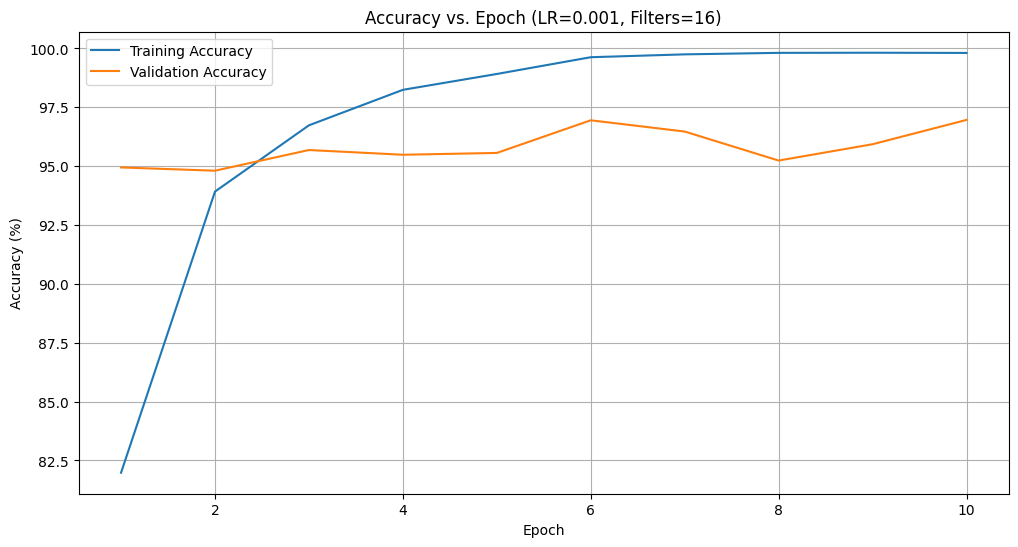

Best Validation Accuracy: 96.97%
Total Training Time: 82.32s
Testing LR=0.001, Filters=32
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Epoch 1/10, Loss: 0.0069, Train Acc: 85.11%, Val Acc: 95.29%, Time: 8.00s
Epoch 2/10, Loss: 0.0019, Train Acc: 95.97%, Val Acc: 95.99%, Time: 7.84s
Epoch 3/10, Loss: 0.0009, Train Acc: 98.13%, Val Acc: 97.10%, Time: 8.03s
Epoch 4/10, Loss: 0.0005, Train Acc: 99.11%, Val Acc: 95.64%, Time: 7.83s
Epoch 5/10, Loss: 0.0004, Train Acc: 99.16%, Val Acc: 96.36%, Time: 8.01s
Epoch 6/10, Loss: 0.0001, Train Acc: 99.81%, Val Acc: 97.00%, Time: 7.77s
Epoch 7/10, Loss: 0.0000, Train Acc: 99.97%, Val Acc: 96.87%, Time: 7.95s
Epoch 8/10, Loss: 0.0000, Train Acc: 99.96%, Val Acc: 96.95%, Time: 7.75s
Epoch 9/10, Loss: 0.0000, Train Acc: 99.96%, Val Acc: 97.23%, Time: 8.02s
Epoch 10/10, Loss: 0.0001, Train Acc: 99.77%, Val Acc: 97.40%, Time: 8.21s


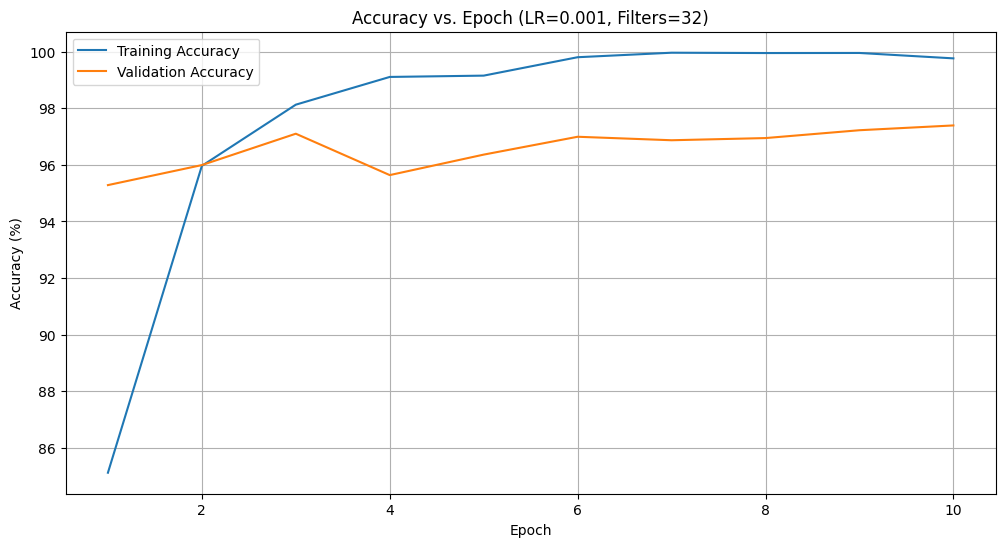

Best Validation Accuracy: 97.40%
Total Training Time: 79.40s
Results for 3.6:
LR=0.01, Filters=16: Best Validation Accuracy = 95.98%
LR=0.01, Filters=32: Best Validation Accuracy = 95.58%
LR=0.001, Filters=16: Best Validation Accuracy = 96.97%
LR=0.001, Filters=32: Best Validation Accuracy = 97.40%


In [29]:
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define multiple CNN architectures
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11, input_size=28, num_filters=16):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear((input_size // 4) * (input_size // 4) * (num_filters * 2), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Test different learning rates and filters
learning_rates = [0.01, 0.001]
num_filters = [16, 32]
results_3_6 = []

for lr in learning_rates:
    for filters in num_filters:
        print(f"Testing LR={lr}, Filters={filters}")
        
        # Setup data loaders
        transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        train_dataset = OrganAMNIST(split='train', transform=transform, download=True)
        val_dataset = OrganAMNIST(split='val', transform=transform, download=True)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        # Initialize model, optimizer, and scheduler
        model = SimpleCNN(num_classes=11, input_size=28, num_filters=filters).to('cuda')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        epoch_times = []

        # Training loop
        train_accuracies, val_accuracies, train_losses = [], [], []
        num_epochs = 10
        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()
            correct_train, total_train, running_loss = 0, 0, 0.0
            for images, labels in train_loader:
                labels = labels.squeeze(1).long().to('cuda')
                images = images.to('cuda')
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            train_acc = 100 * correct_train / total_train
            train_losses.append(running_loss / len(train_loader))
            train_accuracies.append(train_acc)

            # Validation phase
            model.eval()
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    labels = labels.squeeze(1).long().to('cuda')
                    images = images.to('cuda')
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    total_val += labels.size(0)

            val_acc = 100 * correct_val / total_val
            val_accuracies.append(val_acc)
            scheduler.step()

            epoch_time = time.time() - start_time
            epoch_times.append(epoch_time)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

        # Log results
        results_3_6.append((lr, filters, max(val_accuracies)))

        # Plot accuracy vs. epoch
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy vs. Epoch (LR={lr}, Filters={filters})')
        plt.legend()
        plt.grid()
        plt.show()

        total_training_time = sum(epoch_times)
        print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
        print(f"Total Training Time: {total_training_time:.2f}s")


# Summarize results
print("Results for 3.6:")
for result in results_3_6:
    print(f"LR={result[0]}, Filters={result[1]}: Best Validation Accuracy = {result[2]:.2f}%")


Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\finnl_y\.medmnist\organamnist.npz
Epoch [1/10], Loss: 0.2312, Train Acc: 92.33%, Val Acc: 96.15%, Time: 44.27s
Epoch [2/10], Loss: 0.0452, Train Acc: 98.59%, Val Acc: 94.75%, Time: 42.80s
Epoch [3/10], Loss: 0.0273, Train Acc: 99.09%, Val Acc: 95.61%, Time: 43.65s
Epoch [4/10], Loss: 0.0169, Train Acc: 99.49%, Val Acc: 95.13%, Time: 42.48s
Epoch [5/10], Loss: 0.0136, Train Acc: 99.59%, Val Acc: 96.16%, Time: 42.75s
Epoch [6/10], Loss: 0.0012, Train Acc: 99.96%, Val Acc: 96.58%, Time: 43.34s
Epoch [7/10], Loss: 0.0001, Train Acc: 100.00%, Val Acc: 96.75%, Time: 42.42s
Epoch [8/10], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 96.95%, Time: 42.44s
Epoch [9/10], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 96.86%, Time: 42.65s
Epoch [10/10], Loss: 0.0000, Train Acc: 100.00%, Val Acc: 96.92%, Time: 45.99s
Best Validation Accuracy for 128x128: 96.95%
Total Training Time fo

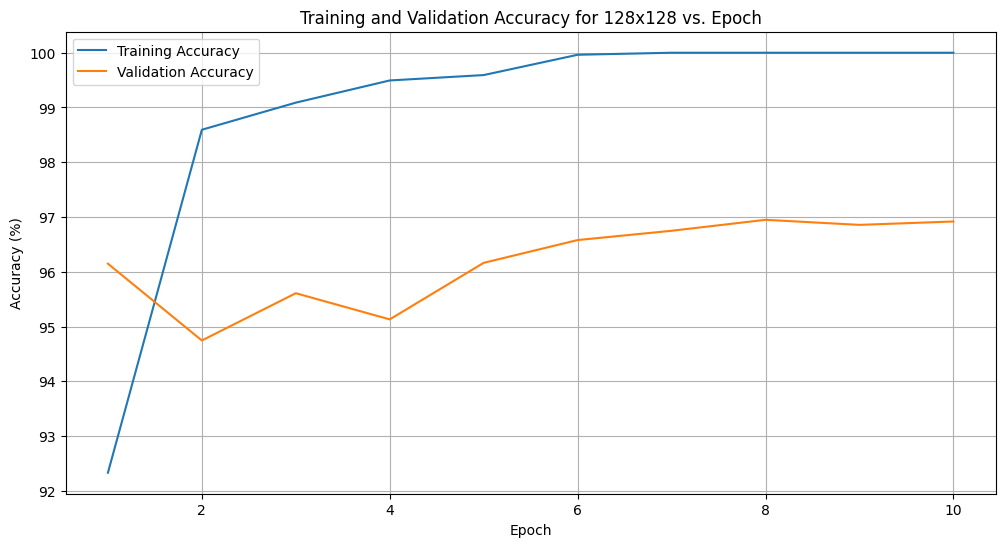

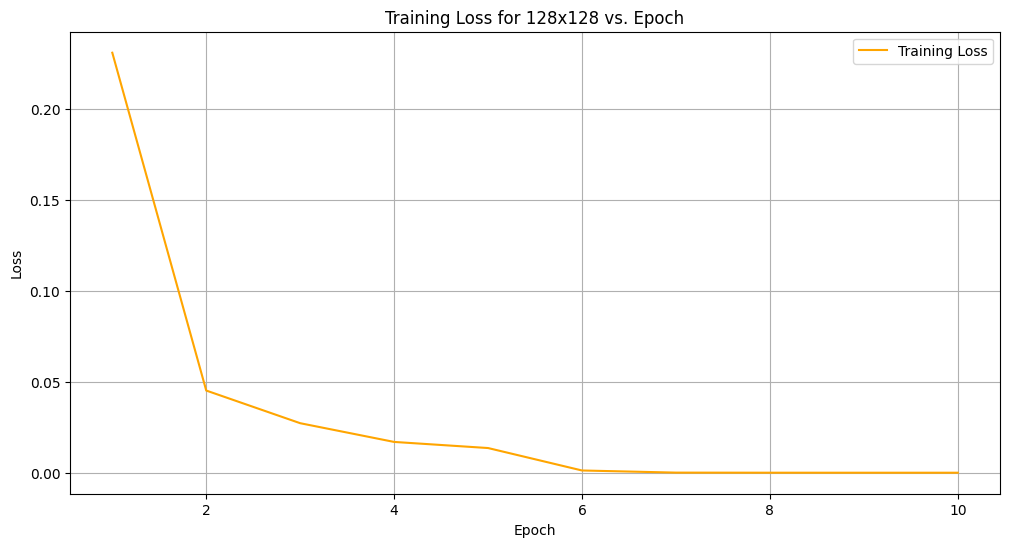

<Figure size 1000x800 with 0 Axes>

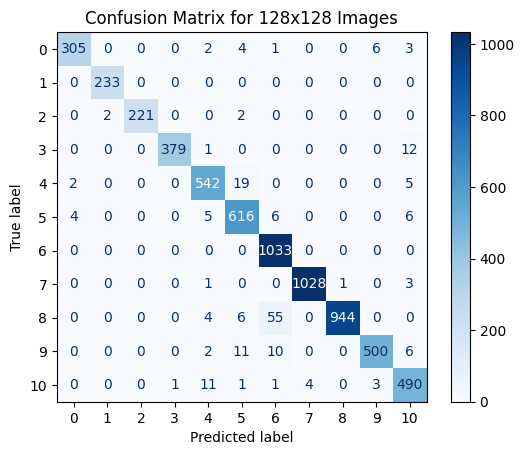

In [30]:
# 3.7

# Define the data preprocessing pipeline for 128x128 images
transform_large = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets for 128x128 images
train_dataset_large = OrganAMNIST(split='train', transform=transform_large, download=True)
val_dataset_large = OrganAMNIST(split='val', transform=transform_large, download=True)

# Create data loaders
train_loader_large = DataLoader(train_dataset_large, batch_size=16, shuffle=True)
val_loader_large = DataLoader(val_dataset_large, batch_size=16, shuffle=False)

# Initialize the model for 128x128 input
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_large = SimpleCNN(num_classes=11, input_size=128, num_filters=32).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer_large = optim.Adam(model_large.parameters(), lr=0.001)  
scheduler_large = optim.lr_scheduler.StepLR(optimizer_large, step_size=5, gamma=0.5)  # Learning rate scheduler

# Training loop for 128x128 images
train_losses_large = []
val_accuracies_large = []
train_accuracies_large = []
epoch_times_large = []

num_epochs = 10  # Number of epochs
for epoch in range(num_epochs):
    start_time = time.time()
    model_large.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    # Training phase
    for images, labels in train_loader_large:
        labels = labels.squeeze(1).long().to(device)
        images = images.to(device)

        optimizer_large.zero_grad()
        outputs = model_large(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_large.step()

        # Track loss and training accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average loss and training accuracy
    epoch_loss = running_loss / len(train_loader_large)
    train_losses_large.append(epoch_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies_large.append(train_acc)

    # Validatio
    model_large.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_large:
            labels = labels.squeeze(1).long().to(device)  # Process labels
            images = images.to(device)

            outputs = model_large(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_accuracies_large.append(val_acc)

    # Learning rate scheduler step
    scheduler_large.step()

    # Calculate epoch time
    epoch_time = time.time() - start_time
    epoch_times_large.append(epoch_time)

    # Log training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Final summary
total_training_time = sum(epoch_times_large)
print(f"Best Validation Accuracy for 128x128: {max(val_accuracies_large):.2f}%")
print(f"Total Training Time for 128x128: {total_training_time:.2f}s")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies_large) + 1), train_accuracies_large, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_large) + 1), val_accuracies_large, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for 128x128 vs. Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses_large) + 1), train_losses_large, label='Training Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for 128x128 vs. Epoch')
plt.legend()
plt.grid()
plt.show()

# Collect all predictions and labels for the confusion matrix
all_preds_large, all_labels_large = [], []
model_large.eval()
with torch.no_grad():
    for images, labels in val_loader_large:
        labels = labels.squeeze(1).long().to(device)
        images = images.to(device)

        outputs = model_large(images)
        _, preds = torch.max(outputs, 1)
        all_preds_large.extend(preds.cpu().numpy()) 
        all_labels_large.extend(labels.cpu().numpy()) 

class_labels = [str(i) for i in range(11)]

# Compute confusion matrix
cm_large = confusion_matrix(all_labels_large, all_preds_large)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_large, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")  # Use a blue color map and format values as integers
plt.title("Confusion Matrix for 128x128 Images")
plt.show()


Testing with 1 FC layers

Epoch [1/10], Loss: 0.6751, Train Acc: 77.77%, Val Acc: 90.53%, Time: 33.68s
Epoch [2/10], Loss: 0.4927, Train Acc: 82.91%, Val Acc: 91.02%, Time: 37.24s
Epoch [3/10], Loss: 0.4577, Train Acc: 84.16%, Val Acc: 89.08%, Time: 34.13s
Epoch [4/10], Loss: 0.4478, Train Acc: 84.47%, Val Acc: 91.33%, Time: 32.77s
Epoch [5/10], Loss: 0.4369, Train Acc: 84.93%, Val Acc: 91.11%, Time: 32.75s
Epoch [6/10], Loss: 0.4116, Train Acc: 85.61%, Val Acc: 91.40%, Time: 32.94s
Epoch [7/10], Loss: 0.4062, Train Acc: 85.82%, Val Acc: 91.88%, Time: 33.12s
Epoch [8/10], Loss: 0.4015, Train Acc: 86.15%, Val Acc: 91.59%, Time: 34.01s
Epoch [9/10], Loss: 0.3998, Train Acc: 85.86%, Val Acc: 91.20%, Time: 33.64s
Epoch [10/10], Loss: 0.3988, Train Acc: 85.96%, Val Acc: 91.54%, Time: 33.65s
Best Validation Accuracy: 91.88%
Total Training Time: 337.94s


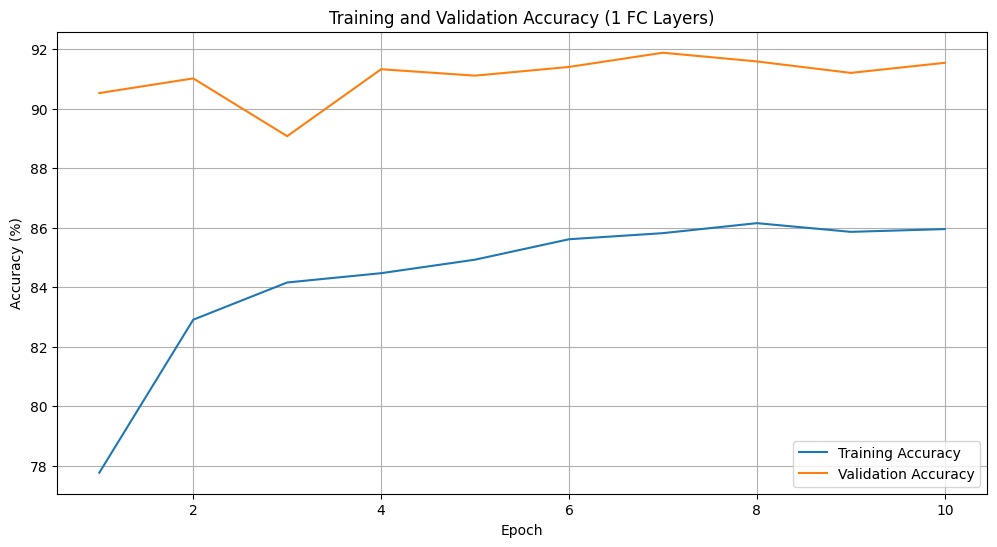

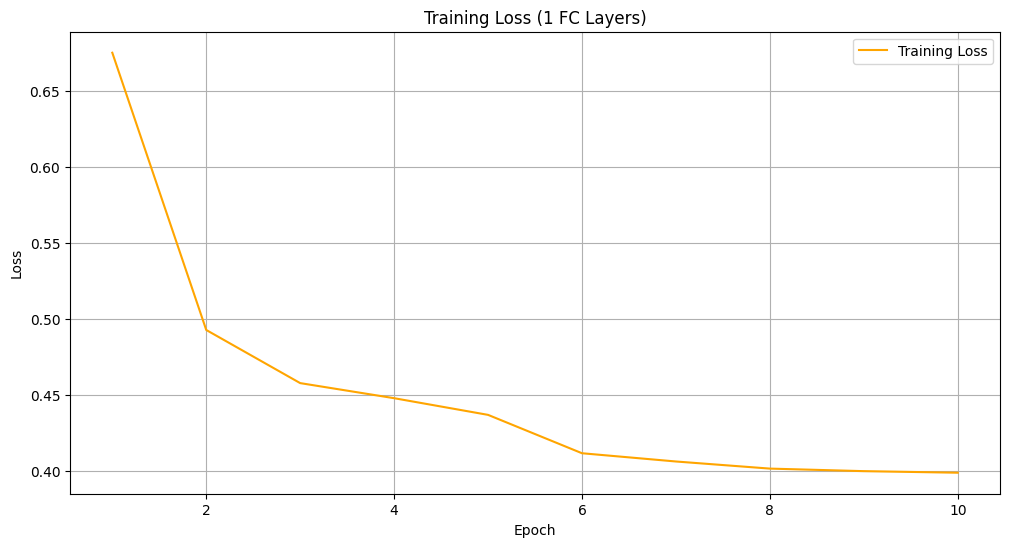


Testing with 2 FC layers

Epoch [1/10], Loss: 0.8040, Train Acc: 72.50%, Val Acc: 91.54%, Time: 35.22s
Epoch [2/10], Loss: 0.6183, Train Acc: 78.51%, Val Acc: 92.07%, Time: 36.57s
Epoch [3/10], Loss: 0.5642, Train Acc: 80.37%, Val Acc: 92.94%, Time: 35.59s
Epoch [4/10], Loss: 0.5496, Train Acc: 80.92%, Val Acc: 92.70%, Time: 35.14s
Epoch [5/10], Loss: 0.5270, Train Acc: 81.96%, Val Acc: 90.49%, Time: 35.17s
Epoch [6/10], Loss: 0.4554, Train Acc: 84.15%, Val Acc: 92.07%, Time: 36.55s
Epoch [7/10], Loss: 0.4442, Train Acc: 84.56%, Val Acc: 92.74%, Time: 35.66s
Epoch [8/10], Loss: 0.4324, Train Acc: 85.03%, Val Acc: 92.64%, Time: 35.29s
Epoch [9/10], Loss: 0.4336, Train Acc: 85.15%, Val Acc: 93.08%, Time: 35.41s
Epoch [10/10], Loss: 0.4234, Train Acc: 85.52%, Val Acc: 93.22%, Time: 36.25s
Best Validation Accuracy: 93.22%
Total Training Time: 356.84s


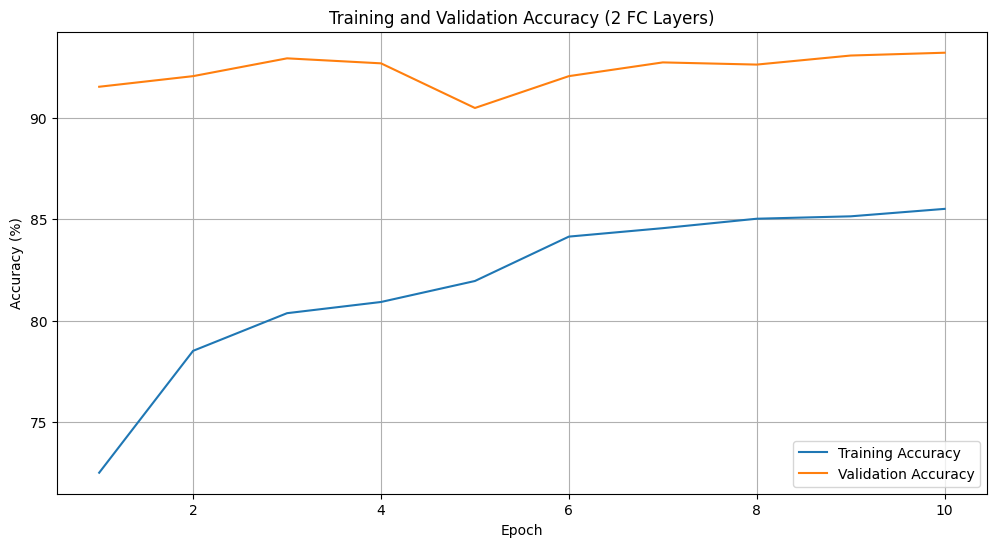

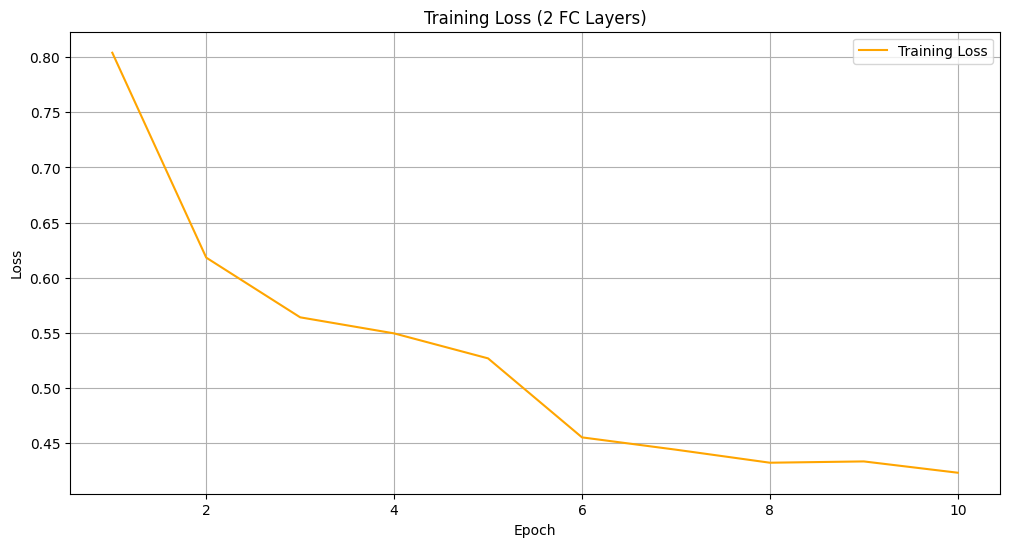


Testing with 3 FC layers

Epoch [1/10], Loss: 0.9596, Train Acc: 66.82%, Val Acc: 91.03%, Time: 37.21s
Epoch [2/10], Loss: 0.7001, Train Acc: 76.26%, Val Acc: 89.40%, Time: 37.53s
Epoch [3/10], Loss: 0.6332, Train Acc: 78.72%, Val Acc: 91.73%, Time: 36.16s
Epoch [4/10], Loss: 0.6151, Train Acc: 79.68%, Val Acc: 91.79%, Time: 35.88s
Epoch [5/10], Loss: 0.5939, Train Acc: 80.39%, Val Acc: 92.11%, Time: 36.37s
Epoch [6/10], Loss: 0.5249, Train Acc: 82.82%, Val Acc: 92.99%, Time: 37.47s
Epoch [7/10], Loss: 0.5050, Train Acc: 83.12%, Val Acc: 91.80%, Time: 36.94s
Epoch [8/10], Loss: 0.4870, Train Acc: 83.92%, Val Acc: 92.37%, Time: 36.90s
Epoch [9/10], Loss: 0.4788, Train Acc: 84.21%, Val Acc: 92.99%, Time: 35.68s
Epoch [10/10], Loss: 0.4708, Train Acc: 84.42%, Val Acc: 93.14%, Time: 37.01s
Best Validation Accuracy: 93.14%
Total Training Time: 367.16s


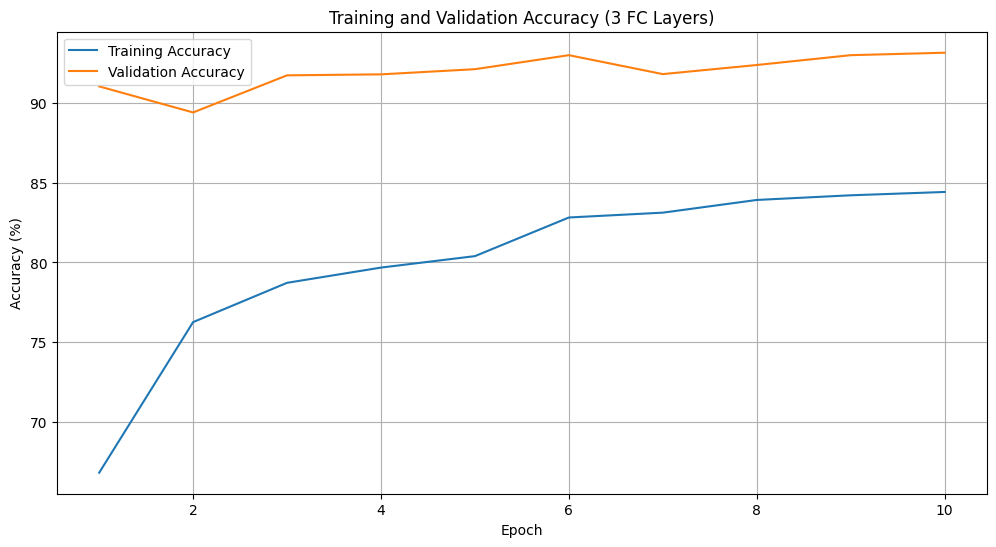

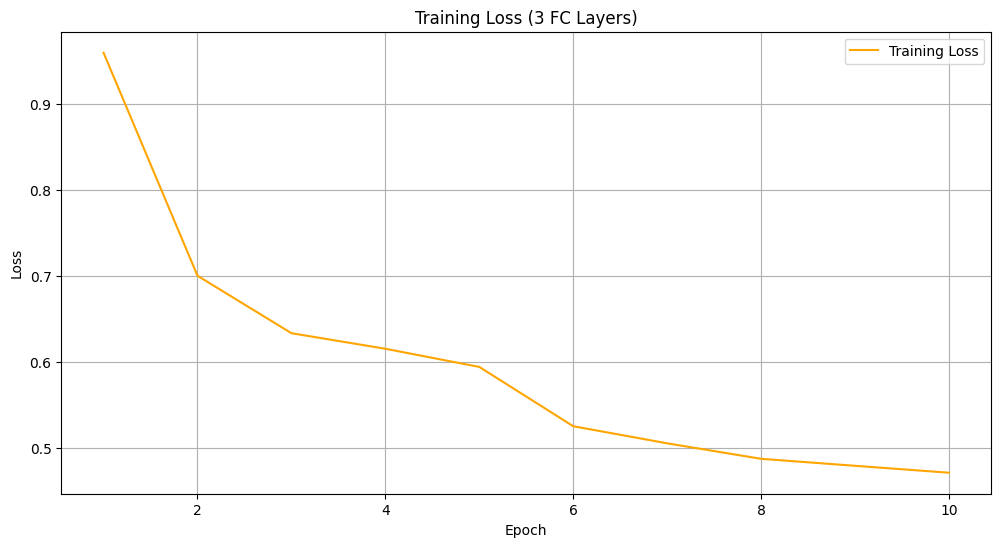


Summary of Results:
FC Layers=1: Best Val Acc=91.88%, Training Time=337.94s
FC Layers=2: Best Val Acc=93.22%, Training Time=356.84s
FC Layers=3: Best Val Acc=93.14%, Training Time=367.16s


In [ ]:
def setup_transfer_learning(num_fc_layers):
    model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Create custom FC layers for different testing cases
    if num_fc_layers == 1:
        model.fc = nn.Linear(512, 11)
    elif num_fc_layers == 2:
        model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 11)
        )
    elif num_fc_layers == 3:
        model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 11)
        )
    else:
        raise ValueError("Unsupported number of FC layers")

    #freeze all layers except FC layers
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

#hyperparameters to test
fc_layers = [1, 2, 3]
learning_rate = 0.001 
results = []

# Training and validation loop for each number of fc layers
for num_fc_layers in fc_layers:
    print(f"\nTesting with {num_fc_layers} FC layers\n")

    # Initialize model, criterion, optimizer, and scheduler
    model_transfer = setup_transfer_learning(num_fc_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=learning_rate)
    scheduler_transfer = optim.lr_scheduler.StepLR(optimizer_transfer, step_size=5, gamma=0.5)

    # Training loop
    train_losses_transfer = []
    val_accuracies_transfer = []
    train_accuracies_transfer = []
    epoch_times_transfer = []
    num_epochs = 10

    for epoch in range(num_epochs):
        start_time = time.time()
        model_transfer.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        # Training phase
        for images, labels in train_loader_large:
            labels = labels.squeeze(1).long().to(device)
            images = images.to(device)

            optimizer_transfer.zero_grad()
            outputs = model_transfer(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_transfer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        # Calculate training loss and accuracy
        epoch_loss = running_loss / len(train_loader_large)
        train_losses_transfer.append(epoch_loss)
        train_acc = 100 * correct_train / total_train
        train_accuracies_transfer.append(train_acc)

        # Validation
        model_transfer.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader_large:
                labels = labels.squeeze(1).long().to(device)
                images = images.to(device)

                outputs = model_transfer(images)
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies_transfer.append(val_acc)

        # Scheduler step
        scheduler_transfer.step()

        # Calculate epoch time
        epoch_time = time.time() - start_time
        epoch_times_transfer.append(epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

    # Final summary
    total_training_time = sum(epoch_times_transfer)
    best_val_acc = max(val_accuracies_transfer)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Total Training Time: {total_training_time:.2f}s")

    # Store results
    results.append({
        'fc_layers': num_fc_layers,
        'train_accuracies': train_accuracies_transfer,
        'val_accuracies': val_accuracies_transfer,
        'train_losses': train_losses_transfer,
        'best_val_acc': best_val_acc,
        'total_training_time': total_training_time
    })

    # Plot training and validation accuracy vs. epoch
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies_transfer) + 1), train_accuracies_transfer, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies_transfer) + 1), val_accuracies_transfer, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy ({num_fc_layers} FC Layers)')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot training loss vs. epoch
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_losses_transfer) + 1), train_losses_transfer, label='Training Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss ({num_fc_layers} FC Layers)')
    plt.legend()
    plt.grid()
    plt.show()


print("\nSummary of Results:")
for res in results:
    print(f"FC Layers={res['fc_layers']}: Best Val Acc={res['best_val_acc']:.2f}%, Training Time={res['total_training_time']:.2f}s")
